# Lesson 5. Reproject Raster 

### Reproject a raster in Python using rasterio.

Data Tip: Proceed with caution when you are reprojecting raster data. Often it’s best to reproject your vector data as reprojecting a raster means that the entire dataset are interpolated and cast into a new grid system. This adds error and uncertainty to your analysis. There are times when you need to reproject your data. However, consider carefully whether you need to do this, before implementimg it in an analysis.

Below you will learn how to reproject raster data to another crs using both a CRS string that you create using the rasterio CRS module and using the crs object from another spatial layer.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from rasterio.crs import CRS
import rioxarray as rxr
import earthpy as et

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

Typically, when it is possible, you want to avoid reprojecting raster data. It’s often easier and carries less error when you reproject the vector layers. However, in this lesson the goal is to learn how to reproject raster data. As such, for this lesson you will reproject a raster layer to align with the CRS of your vector data.

To begin, open up the road centerline data for Boulder, Colorado. Take note of the CRS of the road centerlines **vector data.**

In [2]:
# Get data from Boulder Open Data portal
boulder_roads = gpd.read_file(
    "https://opendata.arcgis.com/datasets/5388d74deeb8450e8b0a45a542488ec8_0.geojson")

boulder_roads.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Next, open up a shapefile that you will use to clip the vector data opened above to the extent of your study area which is LeeHill Road in Boulder, Colorado.

In [3]:
# Clip the boulder data to the extent of the study area aoo
aoi_path = os.path.join("colorado-flood",
                        "spatial",
                        "boulder-leehill-rd",
                        "clip-extent.shp")

# Open crop extent (your study area extent boundary)
crop_extent = gpd.read_file(aoi_path)
# Reproject the crop extent data to match the roads layer.
crop_extent_wgs84 = crop_extent.to_crs(boulder_roads.crs)

# Clip the buildings and roads to the extent of the study area using geopandas
roads_clip = gpd.clip(boulder_roads, crop_extent_wgs84)

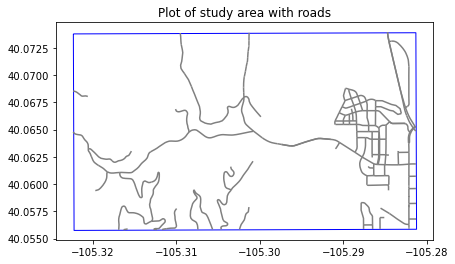

In [4]:
# Plot the clipped data
f, ax = plt.subplots(figsize=(10, 4))

crop_extent_wgs84.plot(ax=ax,
                       edgecolor="blue",
                       color="white")

roads_clip.plot(ax=ax,
                color="grey")
ax.set(title="Plot of study area with roads")
plt.show()

### Open Up Your Raster Data
Next, you will open up the digital terrain model for your study area. Note the CRS of your raster data which is UTM zone 13 epgs 32613.

In [5]:
# Open up a DTM
lidar_dem_path = os.path.join("colorado-flood",
                              "spatial",
                              "boulder-leehill-rd",
                              "pre-flood",
                              "lidar",
                              "pre_DTM.tif")

lidar_dem = rxr.open_rasterio(lidar_dem_path,
                              masked=True).squeeze()
# CHeck the CRS
lidar_dem.rio.crs

CRS.from_epsg(32613)

Below you plot your data. Notice that the data in the plot do not line up as you need it to for processing.

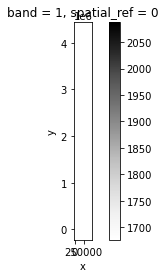

In [6]:
# When you try to overlay the building footprints the data don't line up
f, ax = plt.subplots()
lidar_dem.plot.imshow(ax=ax,
                      cmap='Greys')
roads_clip.plot(ax=ax)

plt.show()

##### Plot showing what happens when the data are not in the same CRS. The data do not plot properly.

###Reproject Your Raster Data Using RioXarray
You can reproject your data using the crs of the roads data using rioxarray. Below, you reproject your data using:

xarray-object-name.rio.reproject(crs-value-here)

You can provide the crs by

- grabbing the CRS of another spatial layer
- as an Proj4 string

Below you use the crs value for the Geopandas layer that you opened above.

In [8]:
# Reproject the data using the crs from the roads layer
lidar_dem_wgs84 = lidar_dem.rio.reproject(roads_clip.crs)
lidar_dem_wgs84.rio.crs

CRS.from_epsg(4326)

Below you reproject the same data using a Proj4 string. Note that either approach will work well. This lesson simply shows you both options!

In [9]:
# Reproject the data to another crs - 4326?

# Create a rasterio crs object for wgs 84 crs - lat / lon
crs_wgs84 = CRS.from_string('EPSG:4326')

# Reproject the data using the crs object
lidar_dem_wgs84_2 = lidar_dem.rio.reproject(crs_wgs84)
lidar_dem_wgs84_2.rio.crs

CRS.from_epsg(4326)

Once the data have been reprojected, you can plot the DEM with the roads layer and it will line up.

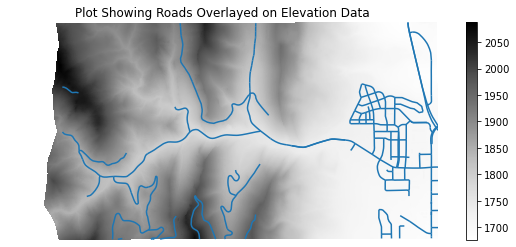

In [10]:
# Plot your newly converted data
f, ax = plt.subplots(figsize=(10, 4))

lidar_dem_wgs84.plot.imshow(ax=ax,
                            cmap='Greys')
roads_clip.plot(ax=ax)
ax.set(title="Plot Showing Roads Overlayed on Elevation Data")
ax.set_axis_off()
plt.show()

# Challenge: Reproject a Hillshade Layer
Below there is code to open up a hillshade for this same study area. Reproject the hillshade object using rioxarray. Then add it to the map that you created above as an underlay.

HINT: you can set the alpha= parameter to a value less than 1 to add transparency to a layer in your plot.

In [11]:
# Open up a hillshade
lidar_dem_path_hill = os.path.join("colorado-flood",
                                   "spatial",
                                   "boulder-leehill-rd",
                                   "pre-flood",
                                   "lidar",
                                   "pre_DTM_hill.tif")

lidar_dem_hill = rxr.open_rasterio(lidar_dem_path_hill,
                                   masked=True).squeeze()
# CHeck the CRS
lidar_dem_hill.rio.crs

CRS.from_epsg(32613)

In [12]:
# Reproject the data using the crs from the roads layer
lidar_dem_hill = lidar_dem_hill.rio.reproject(roads_clip.crs)
lidar_dem_hill.rio.crs

CRS.from_epsg(4326)

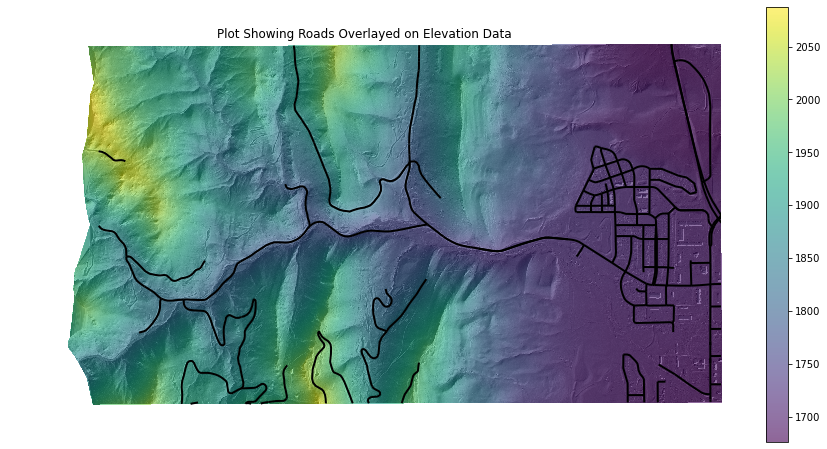

In [25]:
# Plot your newly converted data
f, ax = plt.subplots(figsize=(16, 8))


lidar_dem_hill.plot.imshow(ax=ax,
                            cmap='Greys',
                          add_colorbar=False)
lidar_dem_wgs84.plot.imshow(ax=ax,
                            cmap='viridis',                    
                           alpha=.6)
roads_clip.plot(ax=ax,
               color="black",
                linewidth=2)
ax.set(title="Plot Showing Roads Overlayed on Elevation Data")
ax.set_axis_off()
plt.show()